# Business Case - Grifols S.A.

## The Company

Grifols is a global healthcare company and leading producer of plasma-derived medicines, founded in Spain in 1909, serving over 110 countries with a workforce exceeding 23,800. The company specializes in blood plasma-based products, where it is a European leader and third worldwide, also providing other biopharmaceuticals, transfusion medicine supplies, and clinical diagnostic technologies. Additionally, Grifols offers biological supplies for life-science research, clinical trials, and manufacturing, focusing on immunology, infectious diseases, pulmonology, and critical care.

## The Data

There are two datasets available for this case.
1. Return Donor Fees: provides the data center and the fees offered to the donors.
2. Return Donor Donations: provides the donation center, the donor ID, and the donation date.

## The Case
Analyzing the data, the objective is to answer the following business questions:
> **How are costs and donations trending over time?** <br>
Is there a particular center that is contributing in an outsized way to the overall performance trend?

> **Which compensation structure is most effective at driving total donations?**<br>
Which compensation structure is most cost effective?

> **Balancing the two above, what is your strategic recommendation for compensation going forward?**

## Executive Summary

Grifols S.A. is a prominent global healthcare company specializing in plasma-derived medicines. This analysis focused on donor behavior and associated costs across three donation centers (A, B, and C) from January to June 2025, with a goal to understand cost and donation trends, and the effectiveness of different compensation structures.

Key findings indicate that Donation Center A significantly outperforms Centers B and C in terms of both unique donors and total donations. However, Center A also incurs the highest costs. Statistical analysis confirmed the significant performance differences of Center A compared to B and C, while Centers B and C showed no significant difference between each other. Time series forecasting using AutoARIMA models successfully predicted future donation volumes and costs for all centers, demonstrating clear weekly seasonality and providing a robust basis for strategic recommendations.

## Results Analysis

### Data Overview and Initial Insights
- The dataset spans from January 1, 2025, to June 30, 2025.
- Donors show a preference for donating in the middle of the month and around Thursdays.
- Approximately 40% of donors make a second donation within the same week, highlighting the importance of the second donation incentive.

### Statistical Differences Between Donation Centers
- **Homoscedasticity Test (Levene's Test):** Variances of donations per week across centers were found to be equal (p-value = 0.96), confirming the suitability for ANOVA-like post-hoc tests.
- **Pairwise Tukey's Test:**
    - **Center A vs. Center B:** A significant and strong difference was observed (p < 0.000002, Hedges' g = 1.40), with Center A averaging 261 more donations per week than Center B.
    - **Center A vs. Center C:** A significant and strong difference was also found (p < 0.000014, Hedges' g = 1.26), with Center A averaging 238 more donations per week than Center C.
    - **Center B vs. Center C:** No significant statistical difference was detected (p = 0.89), and the practical difference was negligible (22 donations per week).

### Performance Visualizations
- **Donations Per Week:** Visualizations clearly showed Center A consistently having higher donation volumes throughout the observed period compared to Centers B and C.
- **Unique Donors, Total Donations, and Total Amount Paid:** Bar plots reinforced these findings, indicating that Center A leads in all three metrics. Center A had 28,707 donations from 2,022 unique donors with costs of \$1.49 million, while Centers B and C had similar performance (e.g., Center B: 21,659 donations, 1,859 donors, \$1.16 million cost; Center C: 22,263 donations, 1,523 donors, \$1.14 million cost).

### Time Series Analysis and Forecasting
- **Decomposition:** Seasonal Trend Decomposition using Loess (STL) was applied to daily donation and cost data for each center. This revealed clear weekly seasonality (period=7) in both donations and costs.
- **Stationarity Testing (ADF Test):** The Augmented Dickey-Fuller test indicated that all analyzed time series (donations and costs for Centers A, B, C) were non-stationary (p-values > 0.05).
- **Forecasting Model (AutoARIMA):** AutoARIMA models, configured with a seasonal length of 7 days, were used to forecast donations and costs 60 days into the future. The models demonstrated good fit, with residual checks showing no significant correlation (Ljung-Box Q Test p-values > 0.05).
- **Evaluation Metrics:** The models achieved acceptable accuracy, with Mean Absolute Percentage Error (MAPE) ranging from approximately 6% to 15% across different centers and metrics. For instance, MAPE for donations was 6.26% for A, 12.02% for B, and 13.95% for C. For costs, MAPE was 6.10% for A, 11.85% for B, and 15.58% for C.
- **Forecasted Trends:** The forecasts provide valuable insights into anticipated donation volumes and expenditures for the upcoming two months, enabling proactive resource management and compensation strategy adjustments.

## TL;DR

- **Center A is the top performer** in donations and unique donors but has the highest costs.
- **Centers B and C perform similarly** to each other but significantly less than Center A.
- **Donations and costs show weekly patterns**, effectively captured by time series models.
- **Forecasts provide future trends** for donations and costs, crucial for planning and optimizing compensation strategies.

## Imports

In [5]:
!pip install statsforecast pingouin --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.8 MB/s eta 0:00:00


In [6]:
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Statistics
import scipy.stats as stats
import pingouin as pg

# Time Series Analysis
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import pipeline, trend
from utilsforecast.losses import rmse, mae, mape



## Load the Data
*In this section, we load the data to this notebook and get the first information about it.*

In [3]:
path1= "/content/Return_donor_donations.csv"
path2= "/content/Return_donor_fees.csv"

# Load the datasets
donations = pd.read_csv(path1)
fees = pd.read_csv(path2)

# Improve column names for coding
donations.columns = donations.columns.str.lower().str.replace(' ', '_')
fees.columns = fees.columns.str.lower().str.replace(' ', '_')

# View data
display(donations.head(2))
print(f'\nData shape: {donations.shape}')
print(f'\nData Types:\n')
print(donations.info())

print("\n", "-"*50, "\n")

display(fees.head())
print(f'\nData shape: {fees.shape}')
print(f'\nData Types:\n')
print(fees.info())

,donation_center,donorid,donation_date
0,A,A-1,1/14/2025
1,A,A-1,1/17/2025



Data shape: (72629, 3)

Data Types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72629 entries, 0 to 72628
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   donation_center  72629 non-null  object
 1   donorid          72629 non-null  object
 2   donation_date    72629 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None

 -------------------------------------------------- 



,center,1st_of_the_week,2nd_of_the_week
0,A,40,70
1,B,50,60
2,C,35,75



Data shape: (3, 3)

Data Types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   center           3 non-null      object
 1   1st_of_the_week  3 non-null      int64 
 2   2nd_of_the_week  3 non-null      int64 
dtypes: int64(2), object(1)
memory usage: 204.0+ bytes
None


In [ ]:
# Find out the date range for this dataset
print(f'Date Range: {donations["donation_date"].min()} to {donations["donation_date"].max()}')

Date Range: 1/1/2025 to 6/9/2025


## Data Transformation
*In this section, we will transform the data and make it ready for extracting insights and modeling.*

In [8]:
# Transform the donation_date to a datetime variable
donations['donation_date'] = pd.to_datetime(donations['donation_date'])

# Add columns day, month, year, day of the week and week number
donations['day'] = donations['donation_date'].dt.day
donations['month'] = donations['donation_date'].dt.month
donations['year'] = donations['donation_date'].dt.year
donations['weekday'] = donations['donation_date'].dt.weekday
donations['week'] = donations['donation_date'].dt.isocalendar().week

donations.head(3)

,donation_center,donorid,donation_date,day,month,year,weekday,week
0,A,A-1,2025-01-14,14,1,2025,1,3
1,A,A-1,2025-01-17,17,1,2025,4,3
2,A,A-1,2025-01-23,23,1,2025,3,4


In [9]:
def first_or_second(df):
  # Sort the data ascending by DonorID, then donation date
  df = df.sort_values(by=['donation_center','donorid', 'donation_date'])

  # Identify when a new week starts for a given donor
  # This condition checks if the week is different from the previous donation of the same donor
  # OR if it's the very first donation for that donor (where diff() would be NaN)
  is_first_of_week = (df.groupby(['donation_center', 'donorid'])['week'].diff() != 0) | \
                     (df.groupby(['donation_center', 'donorid'])['week'].diff().isna())

  # Assign 1 for the first donation of the week for a donor, and 2 for subsequent ones in the same week
  df['first_or_second'] = np.where(is_first_of_week, 1, 2)

  # Return transformed data
  return df

# Add first or second donation of the week and fees to the data
donations_fees = first_or_second(donations)
donations_fees['amount'] = np.select(
    condlist=[(donations_fees.donation_center == 'A') & (donations_fees.first_or_second == 1),
              (donations_fees.donation_center == 'A') & (donations_fees.first_or_second == 2),
              (donations_fees.donation_center == 'B') & (donations_fees.first_or_second == 1),
              (donations_fees.donation_center == 'B') & (donations_fees.first_or_second == 2),
              (donations_fees.donation_center == 'C') & (donations_fees.first_or_second == 1),
              (donations_fees.donation_center == 'C') & (donations_fees.first_or_second == 2)],
    choicelist=[40, 70,
                50, 60,
                35, 75],
    default=0
)


In [10]:
# View transformations
donations_fees.head()

,donation_center,donorid,donation_date,day,month,year,weekday,week,first_or_second,amount
0,A,A-1,2025-01-14,14,1,2025,1,3,1,40
1,A,A-1,2025-01-17,17,1,2025,4,3,2,70
2,A,A-1,2025-01-23,23,1,2025,3,4,1,40
3,A,A-1,2025-01-25,25,1,2025,5,4,2,70
4,A,A-1,2025-01-30,30,1,2025,3,5,1,40


In [11]:
# Statistical description
donations_fees.describe().round(2)

,donation_date,day,month,year,weekday,week,first_or_second,amount
count,72629,72629.00,72629.00,72629.0,72629.00,72629.0,72629.00,72629.00
mean,2025-04-01 17:17:26.210191616,15.87,3.52,2025.0,2.66,13.87,1.40,52.44
min,2025-01-01 00:00:00,1.00,1.00,2025.0,0.00,1.0,1.00,35.00
25%,2025-02-15 00:00:00,8.00,2.00,2025.0,1.00,7.0,1.00,40.00
50%,2025-04-02 00:00:00,16.00,4.00,2025.0,3.00,14.0,1.00,50.00
75%,2025-05-16 00:00:00,23.00,5.00,2025.0,4.00,20.0,2.00,70.00
max,2025-06-30 00:00:00,31.00,6.00,2025.0,6.00,27.0,2.00,75.00
std,NaN,8.69,1.71,0.0,1.79,7.44,0.49,14.57


From the statistical descriptions, we can see some interesting high level insights:
* The date range is from Jan 1, 2025 to June 30, 2025
* Donations have mean and median close to the 16th of the month, showing that the donors prefer the middle of the month to donate.
* Considering Monday (0) and Sunday (6), the average donors cluster around Thursday.
* 40% of the donors donate a second time.

## Quick Stats Tests
*Let's check if the Donation Centers are different compared to each other.*

In [17]:
# Check donations counts by center
donations_count = (
    donations_fees
    .groupby(['donation_center', 'week'])
    .donorid.count()
    .reset_index()
    .rename(columns={'donorid':'donations'})
    )

In [19]:
# Checking for equal variances of the samples (Pre and Post)
# This can be done with Levene's test.
pg.homoscedasticity(donations_count, dv='donations',
                               group='donation_center',
                               method='levene', alpha=0.05)

,W,pval,equal_var
levene,0.038859,0.961904,True


Since the variances of donations by center are equal, let's use the Tukey's test to check if they are statistically different

In [20]:
# Tukey's Test
pg.pairwise_tukey(donations_count, dv='donations', between='donation_center')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,1063.222222,802.185185,261.037037,48.564536,5.375055,0.000002,1.403321
1,A,C,1063.222222,824.555556,238.666667,48.564536,4.914423,0.000014,1.259098
2,B,C,802.185185,824.555556,-22.370370,48.564536,-0.460632,0.889805,-0.134125


**Interpreting the Results:**
* **A vs. B**: Significant and strong ( *hedges > 1* ). 261 per week on average.
* **A vs. C**: Significant and strong ( *hedges > 1* ). 238 per week on average.
* **B vs. C**: Not significant and no practical difference. 22 per week on average.

## Insights
*In this section, let's collect insights to start answering the business questions*

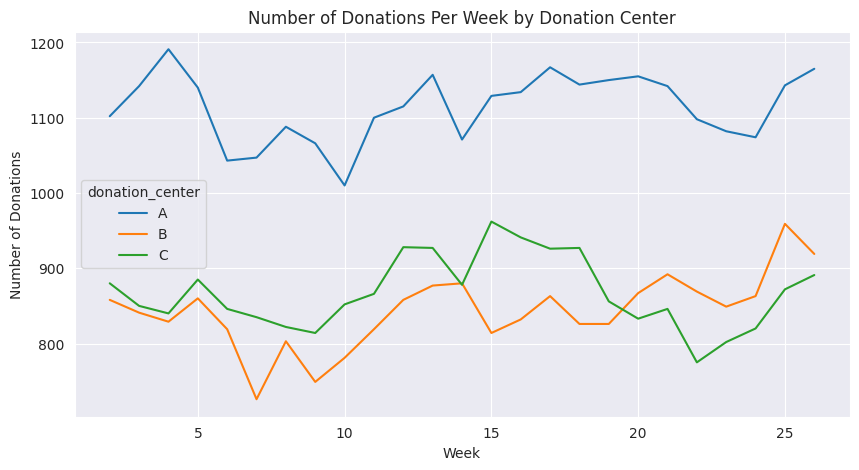

In [23]:
# Format data to plot
toplot = (
    donations_fees
    .query('week not in [1,27]') # remove weeks 1 and 27 as they are incomplete
    .groupby(['donation_center', 'week'])
    ['donorid'].count()
    .reset_index()
)

# Plot
plt.figure(figsize=(10,5))
plt.title('Number of Donations Per Week by Donation Center')
plt.ylabel('Number of Donations')
plt.xlabel('Week')
sns.lineplot(data=toplot, x='week', y='donorid', hue='donation_center');


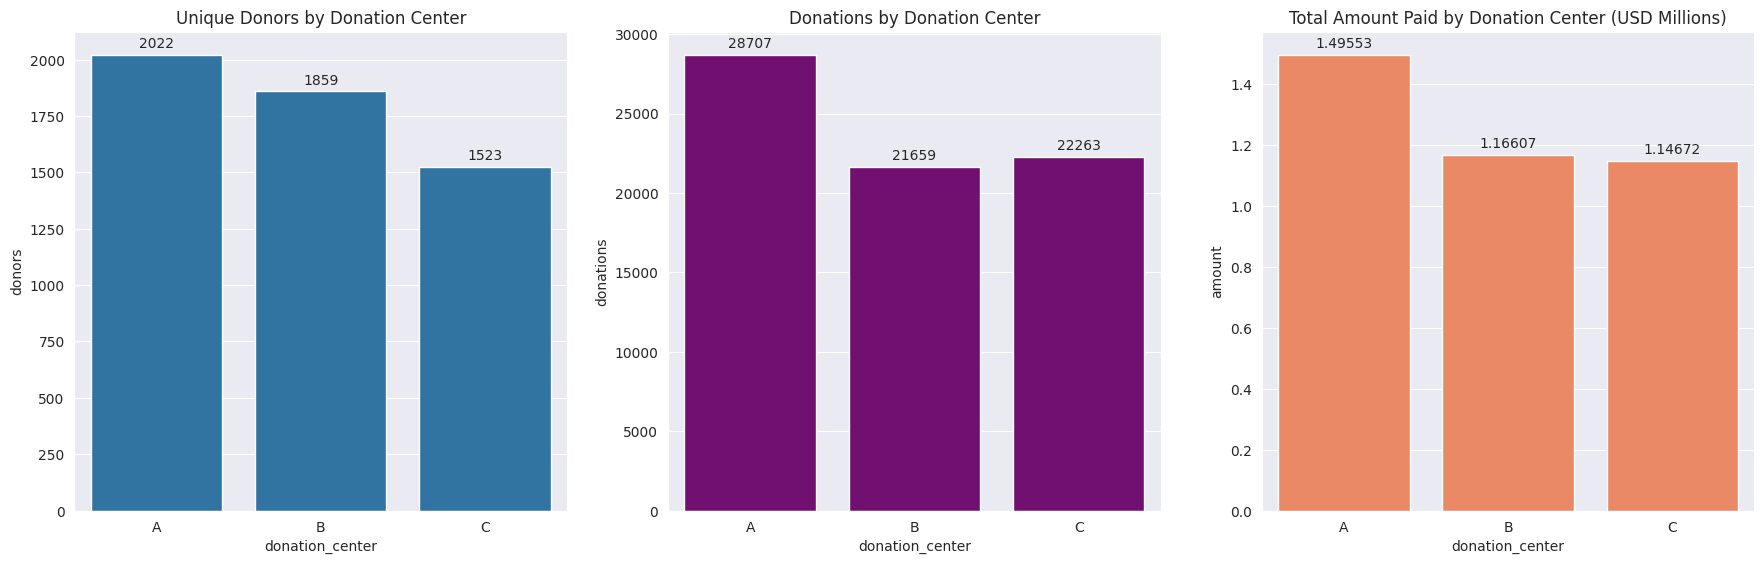

In [24]:
# Format data to plot
toplot = (
    donations_fees
    .groupby(['donation_center'])
    .agg({'donorid':['count', 'nunique'],
          'amount': 'sum'})
    .reset_index()
    .droplevel(axis=1, level=0)
    # rename columns to don_center, count, unique, amount
    .rename(columns={'': 'donation_center', 'count': 'donations', 'nunique': 'donors', 'sum': 'amount'})
    # .melt(id_vars=['donation_center'], value_vars=['donations','donors', 'amount'])
)

# Creating a grid figure with matplotlib
fig, my_grid = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# Plot 1
g1 = sns.barplot(data=toplot, x='donation_center', y='donors', ax=my_grid[0])
# Title of the Plot 1
g1.set_title('Unique Donors by Donation Center')

# Plot 2
g2 = sns.barplot(data=toplot, x='donation_center', y='donations',
                 color='purple', ax=my_grid[1])
# Title of the Plot 2
g2.set_title('Donations by Donation Center')

# Plot 3
g3 = sns.barplot(data=toplot, x='donation_center', y=toplot.amount/1000000,
                 color='coral', ax=my_grid[2])
# Title of the Plot 3
g3.set_title('Total Amount Paid by Donation Center (USD Millions)')

# THE ANNOTATION MAGIC
for ax in my_grid:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=10)

plt.tight_layout(pad=2)
plt.show()


## Trends

In [30]:
from numpy.random import triangular
# Function to test stationarity : ADF Test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(' %s: %.3f' % (key, value))
    print('Result: The series is not stationary') if result[1] > 0.05 else print('Result: The series is stationary')

#------------------------------------------------------

# Function to forecast 30 days ahead
def arima_forecast(df, fcast_h, target, levels=[95]):
  # Instantiate Statsforecast
  sf = StatsForecast(models=[AutoARIMA(season_length=7, alias='Forecast')],
                    freq='D',
                    n_jobs=-1)
  # Fit to data
  sf.fit(df,
        id_col='unique_id',
        time_col='donation_date',
        target_col=target)

  # Forecast
  fcst = sf.predict(h=fcast_h, level=levels)

  # Plot
  fig = sf.plot(df,
          id_col='unique_id',
          time_col='donation_date',
          target_col=target,
          forecasts_df=fcst,
          level=levels)

  return fig, fcst

  #------------------------------------------------------

# Function to evaluate forecast
def evaluate_forecast(train, test, fcast_h, target):
  # Instantiate Statsforecast
  sf = StatsForecast(models=[AutoARIMA(season_length=7, alias='Forecast')],
                    freq='D',
                    n_jobs=-1)
  # Fit to data
  sf.fit(train,
        id_col='unique_id',
        time_col='donation_date',
        target_col=target)

  # Residuals
  resid=sf.fitted_[0][0].model_['residuals']

  # Ljun-Box Q Test
  # Ho - No residuals correlation. Good fit of the model.
  # Ha - There is correlation/ pattern in the residuals. Not the best fit.
  print('Residuals check: ETS')
  jung = acorr_ljungbox( resid, lags=[7])
  if jung['lb_pvalue'].values[0] > 0.05:
    print('Residuals are not correlated')
  else:
    print('Residuals are correlated')

  # Forecast
  sf.forecast(h=fcast_h, df=train, fitted=True,
              id_col='unique_id',
              time_col='donation_date',
              target_col=target)

  fitted_values = sf.forecast_fitted_values()
  train["fitted"] = fitted_values[target].values
  train["resid"] = train[target] - train["fitted"]
  train["innov"] = train[target] - train["fitted"]

  # Predict
  fcst = sf.predict(h=fcast_h)
  fcst[target] = test[-fcast_h:][target].values

  # Evaluation
  evaluation = evaluate(fcst, metrics=[rmse, mae, mape], train_df=train,
                        id_col='unique_id',
                        target_col=target,
                        time_col='donation_date')

  return evaluation

### Donation Center A - Donations

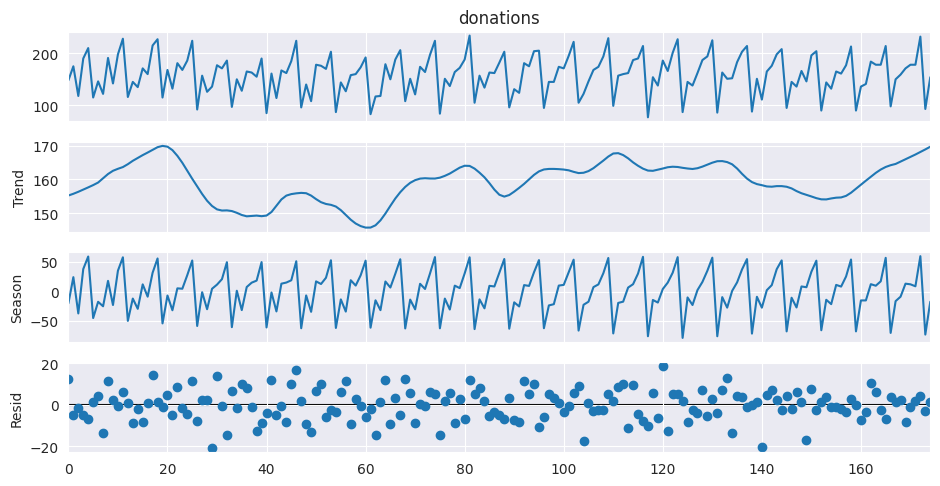

In [26]:
# Isolate Donation Center A
dc_a = (
    donations_fees
    .query('donation_center == "A" & week not in [1,27]', engine='python')
    [['donation_date','week']]
    .resample(rule='D', on='donation_date')
    .count()
    .reset_index()
    .rename(columns={'week':'donations'})
    .assign(unique_id='A')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_a['donations'], period=7).fit()
stl.plot().set_size_inches(10,5)

In [27]:
# Test Stationarity
adf_test(dc_a['donations'])

ADF Statistic: -1.992701
p-value: 0.289783
Critical Values:
 1%: -3.472
 5%: -2.880
 10%: -2.576
Result: The series is not stationary


In [ ]:
traindf = dc_a[:-30].copy()
testdf = dc_a[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='donations', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,A,rmse,13.11345
1,A,mae,9.636219
2,A,mape,0.062632


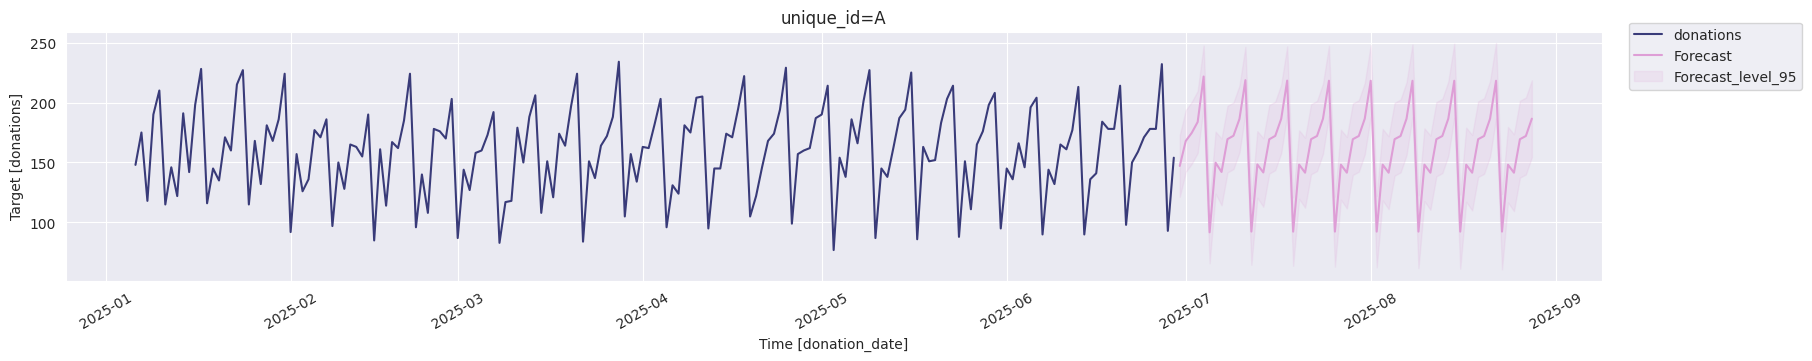

In [31]:
# Forecast Donation Center A Donations
fig, fcast_a = arima_forecast(dc_a, target='donations', fcast_h=60)

fig

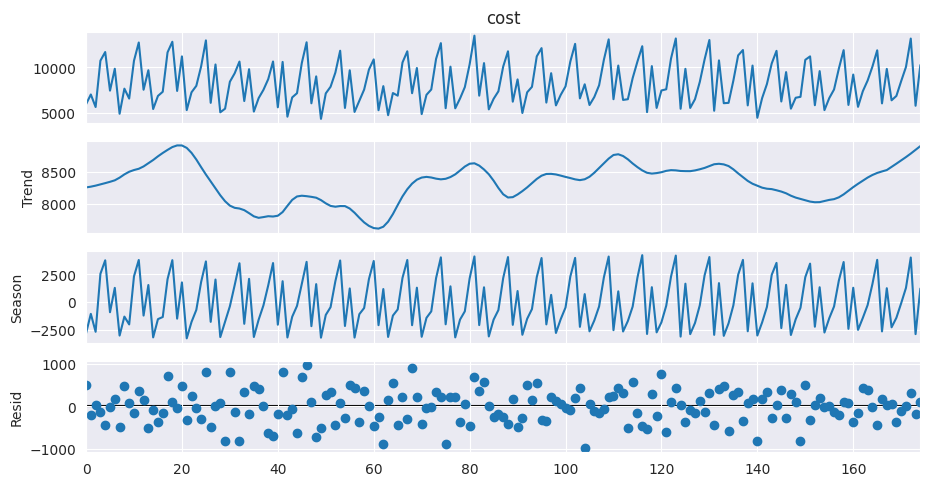

In [38]:
# Isolate Donation Center A
dc_a = (
    donations_fees
    .query('donation_center == "A" & week not in [1,27]', engine='python')
    [['donation_date','amount']]
    .resample(rule='D', on='donation_date')
    .sum()
    .reset_index()
    .rename(columns={'amount':'cost'})
    .assign(unique_id='A')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_a['cost'], period=7).fit()
stl.plot().set_size_inches(10,5)

In [ ]:
traindf = dc_a[:-30].copy()
testdf = dc_a[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='cost', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,A,rmse,620.202662
1,A,mae,497.257292
2,A,mape,0.060960


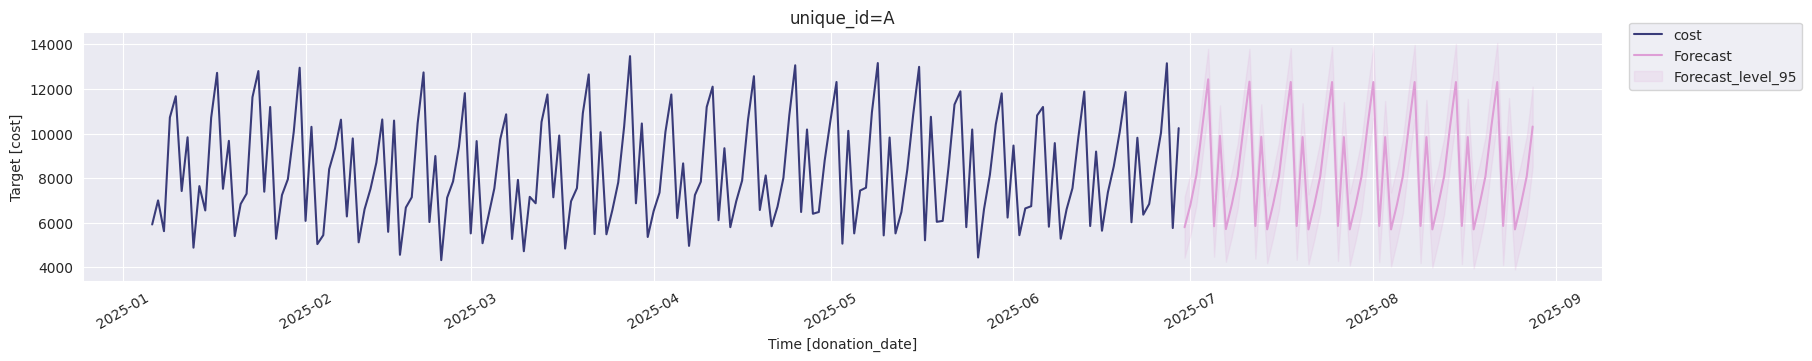

In [39]:
# Forecast Donation Center A Cost
fig, fcast_cost_a = arima_forecast(dc_a, target='cost', fcast_h=60)

fig

### Donation Center B - Donations

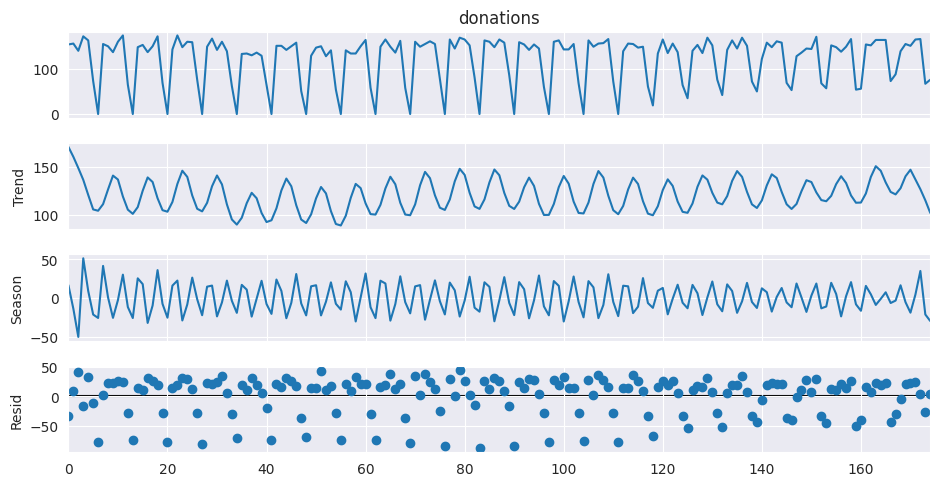

In [34]:
# Isolate Donation Center B
dc_b = (
    donations_fees
    .query('donation_center == "B" & week not in [1,27]', engine='python')
    [['donation_date','week']]
    .resample(rule='D', on='donation_date')
    .count()
    .reset_index()
    .rename(columns={'week':'donations'})
    .assign(unique_id='B')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_b['donations'], period=4).fit()
stl.plot().set_size_inches(10,5)

In [ ]:
# Test Stationarity
adf_test(dc_b['donations'])

ADF Statistic: -1.186718
p-value: 0.679283
Critical Values:
 1%: -3.472
 5%: -2.880
 10%: -2.576
Result: The series is not stationary


In [ ]:
traindf = dc_b[:-30].copy()
testdf = dc_b[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='donations', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,B,rmse,15.738502
1,B,mae,12.198574
2,B,mape,0.120185


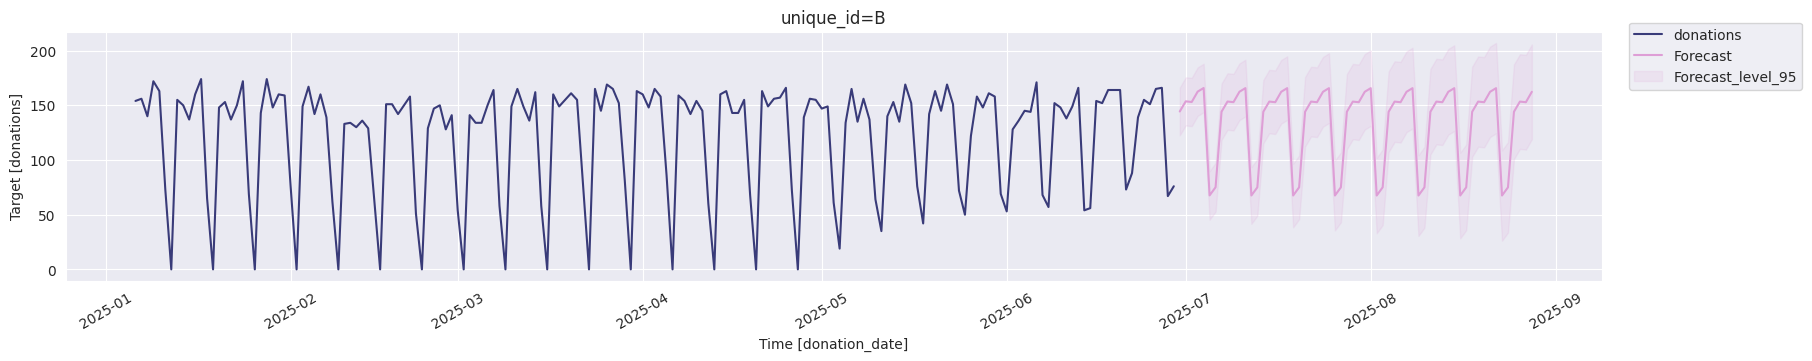

In [35]:
# Forecast Donation Center B Donations
fig, fcast_b = arima_forecast(dc_b, target= 'donations', fcast_h=60)

fig

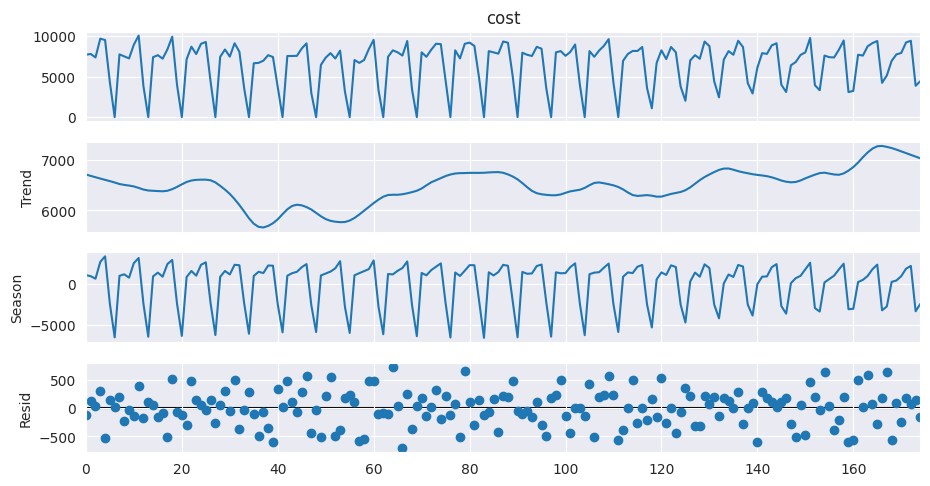

In [36]:
# Isolate Donation Center B
dc_b = (
    donations_fees
    .query('donation_center == "B" & week not in [1,27]', engine='python')
    [['donation_date','amount']]
    .resample(rule='D', on='donation_date')
    .sum()
    .reset_index()
    .rename(columns={'amount':'cost'})
    .assign(unique_id='B')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_b['cost'], period=7).fit()
stl.plot().set_size_inches(10,5)

In [ ]:
traindf = dc_b[:-30].copy()
testdf = dc_b[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='cost', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,B,rmse,865.450436
1,B,mae,658.098975
2,B,mape,0.118518


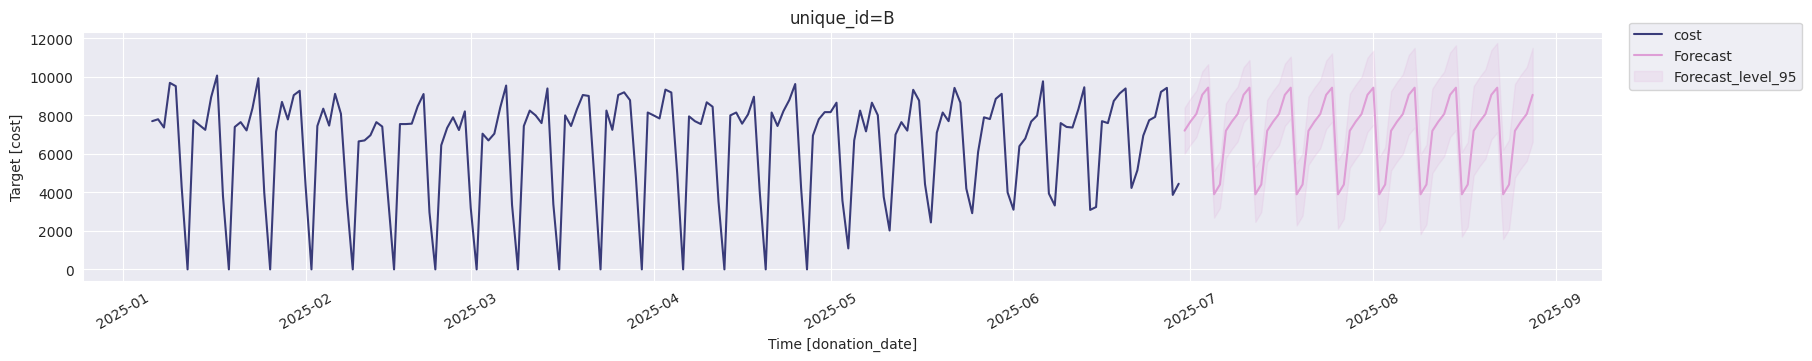

In [37]:
# Forecast Donation Center B Donations
fig, fcast_cost_b = arima_forecast(dc_b, target='cost', fcast_h=60)

fig

### Donation Center C - Donations

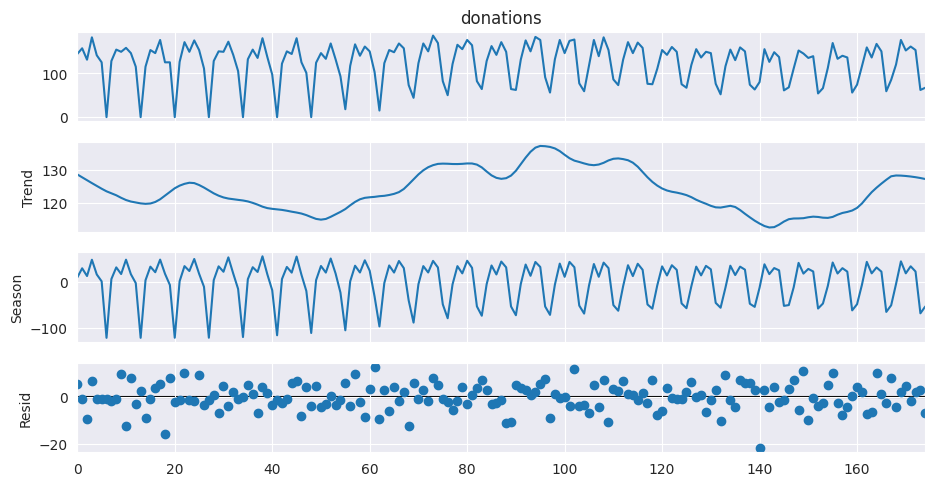

In [40]:
# Isolate Donation Center C
dc_c = (
    donations_fees
    .query('donation_center == "C" & week not in [1,27]', engine='python')
    [['donation_date','week']]
    .resample(rule='D', on='donation_date')
    .count()
    .reset_index()
    .rename(columns={'week':'donations'})
    .assign(unique_id='C')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_c['donations'], period=7).fit()
stl.plot().set_size_inches(10,5)

In [ ]:
# Test Stationarity
adf_test(dc_c['donations'])

ADF Statistic: -1.639867
p-value: 0.462330
Critical Values:
 1%: -3.472
 5%: -2.880
 10%: -2.576
Result: The series is not stationary


In [ ]:
traindf = dc_c[:-30].copy()
testdf = dc_c[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='donations', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,C,rmse,15.324993
1,C,mae,13.696345
2,C,mape,0.139461


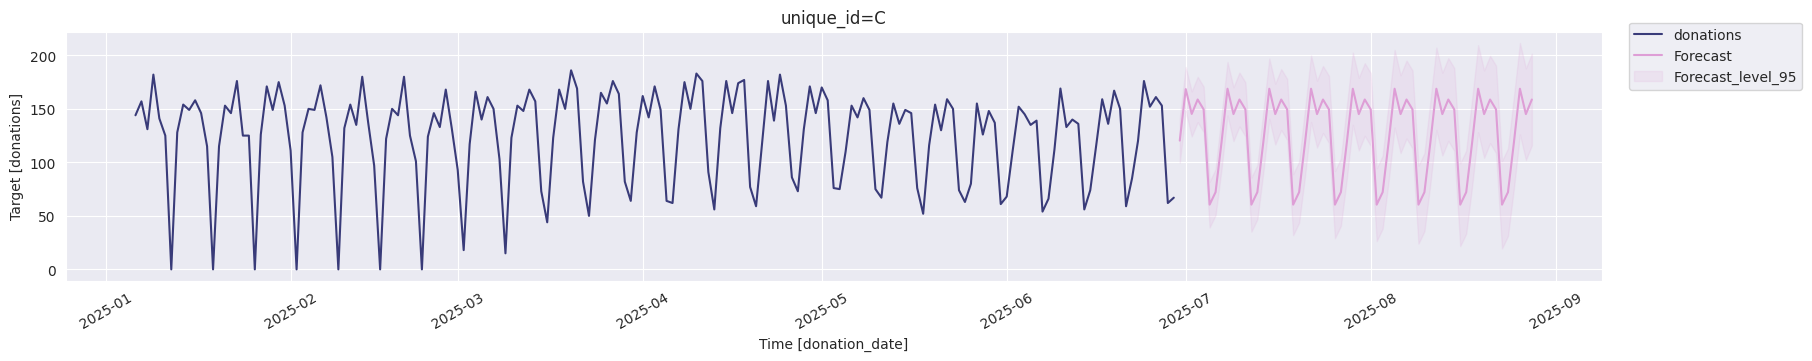

In [41]:
# Forecast Donation Center C Donations
fig, fcast_c = arima_forecast(dc_c, target='donations', fcast_h=60)

fig

#### Cost

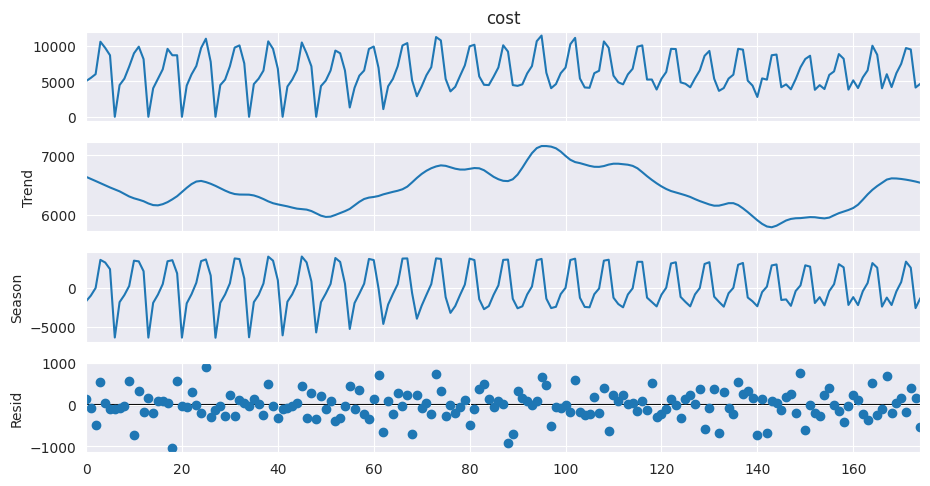

In [42]:
# Isolate Donation Center C
dc_c = (
    donations_fees
    .query('donation_center == "C" & week not in [1,27]', engine='python')
    [['donation_date','amount']]
    .resample(rule='D', on='donation_date')
    .sum()
    .reset_index()
    .rename(columns={'amount':'cost'})
    .assign(unique_id='C')
)

# Seasonal Trend Decomposition (STL)
stl = STL(dc_c['cost'], period=7).fit()
stl.plot().set_size_inches(10,5)

In [ ]:
traindf = dc_c[:-30].copy()
testdf = dc_c[-30:].copy()

# Evaluation
evaluation = evaluate_forecast(traindf, testdf, target='cost', fcast_h=30)

evaluation

Residuals check: ETS
Residuals are not correlated


,unique_id,metric,Forecast
0,C,rmse,968.829344
1,C,mae,838.800415
2,C,mape,0.155847


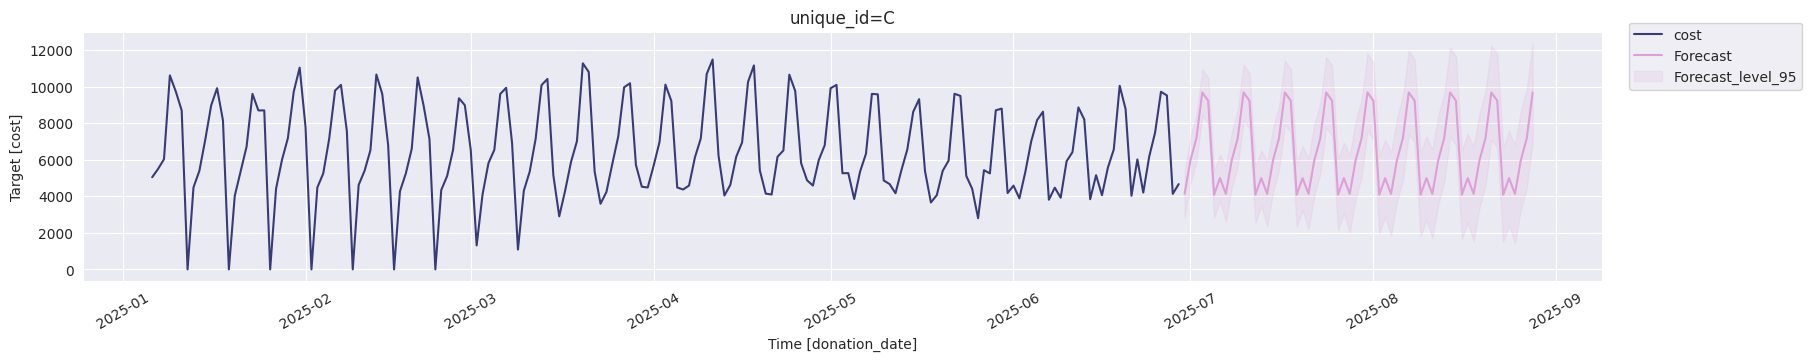

In [43]:
# Forecast Donation Center C Cost
fig, fcast_cost_c = arima_forecast(dc_c, target= 'cost', fcast_h=60)

fig

## Wrap

In [44]:
# All forecasts joined
donations_forecasts = pd.concat([fcast_a, fcast_b, fcast_c], axis=0).rename(columns={'unique_id':'donation_center','Forecast': 'donations'})
cost_forecasts = pd.concat([fcast_cost_a, fcast_cost_b, fcast_cost_c], axis=0).rename(columns={'unique_id':'donation_center','Forecast': 'cost'})

all_forecasts = (
    donations_forecasts[['donation_center', 'donation_date', 'donations']]
    .merge(cost_forecasts[['donation_center', 'donation_date', 'cost']],
           on=['donation_center', 'donation_date'])
    .astype({'donations': 'int', 'cost': 'int'})
    .groupby(['donation_center', 'donation_date'])
    .agg({'donations': 'sum',
          'cost': 'sum'})
    .reset_index()
)

In [45]:
# Append original data + Forecasts
original = (
    donations_fees
    .query('week not in [1,27]')
    .groupby(['donation_center', 'donation_date'])
    .agg({'donorid': 'count',
          'amount': 'sum'})
    .reset_index()
    .rename(columns={'donorid': 'donations',
                     'amount': 'cost'})
    # .resample(rule='W', on='donation_date')
    # .sum()
    .reset_index()
)

In [46]:
# Function to plot forecasts
def plot_forecasts(dc, forecast, title):
  # Original numbers
  original = (
      donations_fees
      .query('week not in [1,27] & donation_center == @dc')
      .groupby(['donation_center', 'donation_date'])
      .agg({'donorid': 'count',
            'amount': 'sum'})
      .reset_index()
      .rename(columns={'donorid': 'donations',
                      'amount': 'cost'})
      .resample(rule='MS', on='donation_date')
      .sum()
      .reset_index()
  )

  # Forecast
  f = forecast.resample(rule='MS', on='donation_date').sum().reset_index()[1:]

  # Plot
  plt.figure(figsize=(10,5))
  plt.title(title)
  plt.bar(original['donation_date'], original['donations'], color='red', width=20, label='Donations')
  plt.bar(f['donation_date'], f['Forecast'], color='royalblue', width=20, label= 'Forecast')
  plt.legend()
  plt.show()

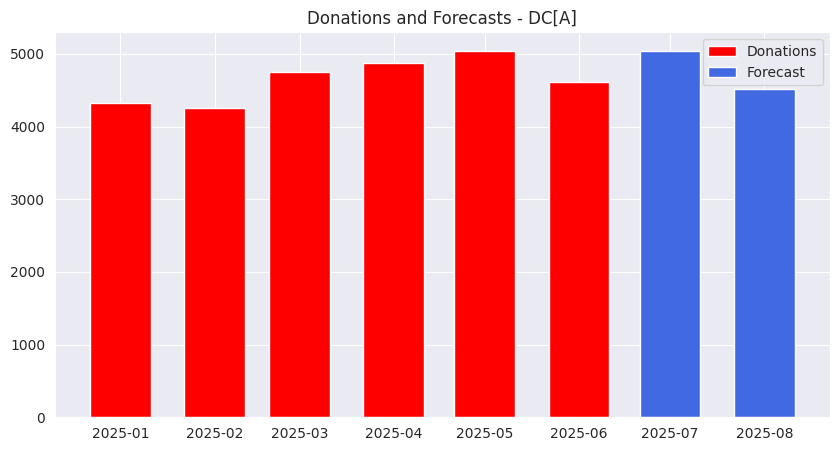

In [47]:
plot_forecasts('A', fcast_a, 'Donations and Forecasts - DC[A]')

In [ ]:
donations_fees.to_csv('donations_fees.csv', index=False)

In [52]:
original['day'] = original['donation_date'].dt.day
original['month'] = original['donation_date'].dt.month
original['year'] = original['donation_date'].dt.year
original['weekday'] = original['donation_date'].dt.weekday
original['week'] = original['donation_date'].dt.isocalendar().week

all_forecasts['day'] = all_forecasts['donation_date'].dt.day
all_forecasts['month'] = all_forecasts['donation_date'].dt.month
all_forecasts['year'] = all_forecasts['donation_date'].dt.year
all_forecasts['weekday'] = all_forecasts['donation_date'].dt.weekday
all_forecasts['week'] = all_forecasts['donation_date'].dt.isocalendar().week

In [53]:
all_forecasts.to_csv('all_forecasts.csv', index=False)
original.to_csv('original.csv', index=False)